Здесь создадим искусственный пример и попробуем отловить баги, если они есть, а также возможно придумать способ улучшить качество алгоритма.

In [62]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [39]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [15]:
def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
def dump_pickle(filepath, obj):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

### Искусственная маска

In [5]:
mask = np.zeros((300, 400))

In [69]:
wood_mask = mask.copy()
wood_mask[50:100, 35:100] = 1
wood_mask[255:270, 150:165] = 1

In [72]:
water_mask = mask.copy()
water_mask[170:240, 200:300] = 1
water_mask[45:90, 320:380] = 1

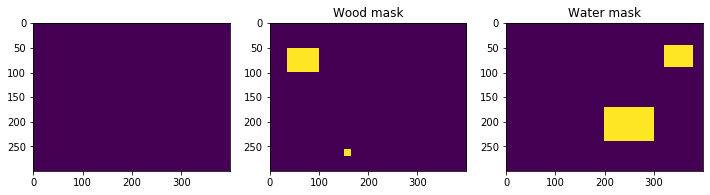

In [73]:
plt.figure(figsize=(12, 9))

plt.subplot(131)
plt.imshow(mask)

plt.subplot(132)
plt.title('Wood mask')
plt.imshow(wood_mask)

plt.subplot(133)
plt.title('Water mask')
plt.imshow(water_mask)

plt.show()

### Маска -> координаты

Ну поехали, копипастим из `quality_asessment_with_predictions.ipynb`

In [74]:
H, W = 300, 400

def rectangle_to_coords(rectangle, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon):
    x1, x2, y1, y2 = rectangle
    
    one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon, 
                                                                    left_bottom_lat, left_bottom_lon, (H, W))
    
    minlat = right_top_lat - (x2 * one_pixel_lat_diff)
    maxlat = right_top_lat - (x1 * one_pixel_lat_diff)
    minlon = left_bottom_lon + (y1 * one_pixel_lon_diff)
    maxlon = left_bottom_lon + (y2 * one_pixel_lon_diff)
    
    return minlat, maxlat, minlon, maxlon

In [75]:
# right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon отберём у какой-нибудь существующей картинки
corners_folder = '../dataset/corners'
corners = read_pickle(os.path.join(corners_folder, '224.pickle'))

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

In [76]:
rectangles_wood = mask_to_rectangles(wood_mask)
print(rectangles_wood)
rectangles_water = mask_to_rectangles(water_mask)
print(rectangles_water)

[(50, 99, 35, 99), (255, 269, 150, 164)]
[(45, 89, 320, 379), (170, 239, 200, 299)]


In [122]:
bounds = []
tags = []

for r in rectangles_wood:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('wood')
    
for r in rectangles_water:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('water')

In [123]:
bounds

[{'maxlon': 32.3359496062992,
  'minlat': 1.4749979035332177,
  'minlon': 32.24806299212597,
  'maxlat': 1.5420371934492758},
 {'maxlon': 32.42520944881888,
  'minlat': 1.2424126119877101,
  'minlon': 32.40598425196849,
  'maxlat': 1.2615666948208695},
 {'maxlon': 32.72045354330707,
  'minlat': 1.4886793912711889,
  'minlon': 32.63943307086613,
  'maxlat': 1.5488779373182613},
 {'maxlon': 32.61059527559054,
  'minlat': 1.2834570752016232,
  'minlon': 32.47464566929133,
  'maxlat': 1.3778593405936235}]

In [124]:
tags

['wood', 'wood', 'water', 'water']

In [125]:
rectangles = [rectangles_wood + rectangles_water]
rectangles

[[(50, 99, 35, 99),
  (255, 269, 150, 164),
  (45, 89, 320, 379),
  (170, 239, 200, 299)]]

### OSM объект для изображения

In [126]:
img_shape = (H, W)

img_osm = Image_OSM_object(
    img_shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)

In [127]:
img_osm.osm_objects

### Попробуем оценить точность по стандартному механизму

In [128]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [129]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [130]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [131]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [132]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [187]:
def calculate_precision_k_for_one(img_cds, max_k):
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point[::-1], img_osm)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [179]:
%%time
is_in_k = calculate_precision_k_for_one(img_cds, max_k=48)

CPU times: user 18.4 s, sys: 29.3 ms, total: 18.4 s
Wall time: 18.4 s


In [180]:
is_in_k = np.array(is_in_k)

In [181]:
is_in_k[:, 0].sum() / is_in_k.shape[0]

0.71

In [182]:
is_in_k[:, 1].sum() / is_in_k.shape[0]

0.85

In [183]:
is_in_k[:, 2].sum() / is_in_k.shape[0]

0.86

Как-то точность не особенно высока получается...

### Посмотрим, что получилось, а что не получилось и почему

In [188]:
def calculate_cell_probs_for_all_points():
    point_to_probs = []
    agent_cds = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point[::-1], img_osm)
        agent_cd.make_fast()
        agent_cds.append(agent_cd)
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        point_to_probs.append((agent_point[::-1], cell_probs))
        
    return point_to_probs, agent_cds

In [140]:
# point_to_probs = calculate_cell_probs_for_all_points()

In [141]:
# point_to_probs

In [198]:
def show_img(img_acc, is_in_1_list):
    print(f"ACCURACY: {img_acc}")              

    # Результаты нескольких предсказаний
    
    bigger_side = 400
    bigger_side_blocks_count = 8
    one_block_len = bigger_side / bigger_side_blocks_count
    half = one_block_len / 2
    
    point_to_probs, agent_cds = calculate_cell_probs_for_all_points()
    
    def _show_results(i):
#         img_copy_copy = img_copy.copy()
            
        point = point_to_probs[i][0]
        agent_cd = agent_cds[i]
        print("SECTORS:", agent_cd.sectors)
        center_point = points_to_centers_6_8[point[::-1]][::-1]

#         cv2.circle(img_copy_copy, (point[0], point[1]), 3, (0, 0, 255), -1) 
#         cv2.rectangle(img_copy_copy,
#              (int(center_point[1] - half), int(center_point[0] - half)),
#              (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)

        plt.figure(figsize=(8, 5))
#         plt.subplot(121)
#         plt.imshow(cv2.cvtColor(img_copy_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"Point: {point_to_probs[i][0]}")
        

        probs = np.array(point_to_probs[i][1])
        max_proba_point_id = np.argmax(probs)
        max_center_point = img_cds.center_points[max_proba_point_id]
    
        probs = probs.reshape((6, 8))
        probs_img = np.repeat(np.repeat(probs,
                                one_block_len
                                , axis=0),
                      one_block_len,
                      axis=1).reshape((H, W))
        points_color = np.min(probs_img)
        cv2.rectangle(probs_img,
             (int(max_center_point[1] - half), int(max_center_point[0] - half)),
             (int(max_center_point[1] + half), int(max_center_point[0] + half)), points_color, 2)
        cv2.circle(probs_img, (point[1], point[0]), 3, points_color, -1)

#         plt.subplot(122)
#         plt.title("Confidences")
        plt.imshow(probs_img)
    
        # Рядом нужно вывести диаграмму для точки, в которую мы решили, что агент попал
        
        
        plt.show()
        
    print("GOOD PREDICTIONS")
    good_predictions_counter = 0
    for i in range(len(point_to_probs)):
        if is_in_1_list[i]:
            print(f"I: {i}")
            _show_results(i)
            
            good_predictions_counter += 1
            if good_predictions_counter == 10:
                break

    print("NOT GOOD PREDICTIONS")
    not_good_predictions_counter = 0
    for i in range(len(point_to_probs)):
        if not is_in_1_list[i]:
            print(f"I: {i}")
            _show_results(i)
            
            not_good_predictions_counter += 1
            if not_good_predictions_counter == 10:
                break


ACCURACY: 0.71
GOOD PREDICTIONS
I: 0
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.83328963467625, 'water')], [(317.

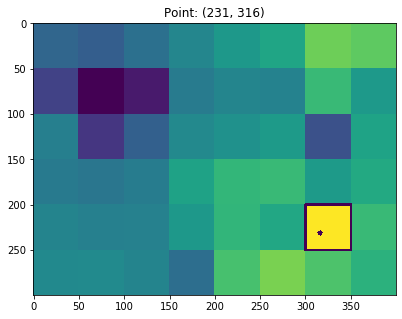

I: 3
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water')], [(243.232399157678, 'water

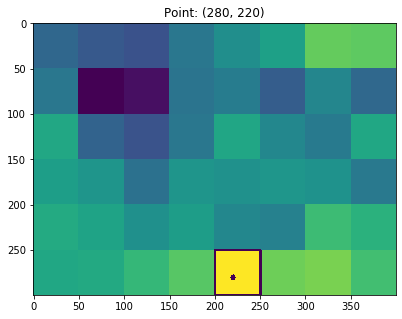

I: 4
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

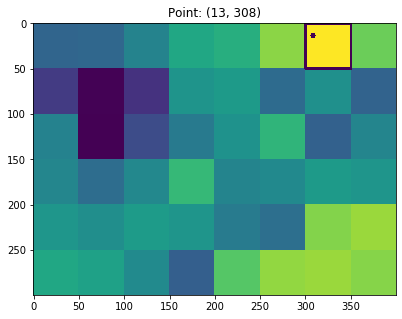

I: 5
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

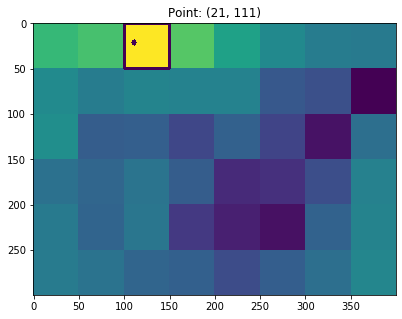

I: 6
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.4306641891518, 'water')], [(297.430

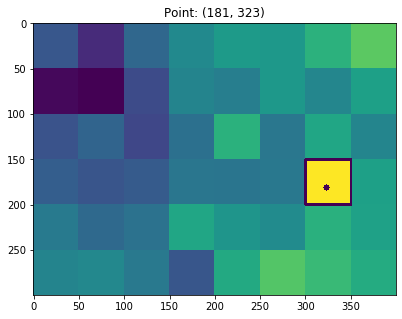

I: 7
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360.0013888862097, 'water')], [(360

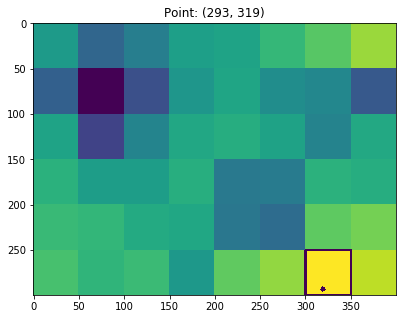

I: 8
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

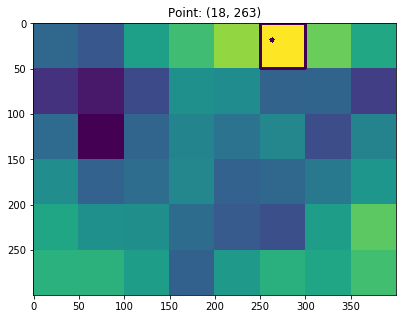

I: 9
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

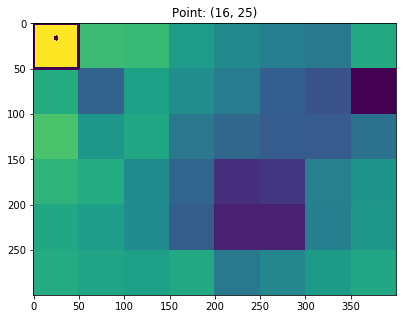

I: 11
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [(213.77090541044166, 'water')], [

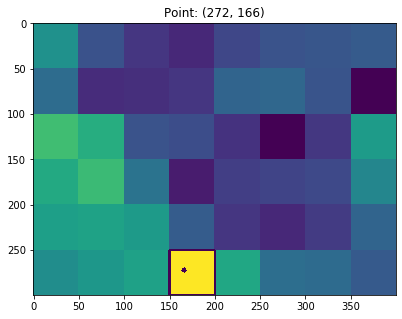

I: 12
SECTORS: [[], [], [], [], [], [], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(65.00769185258002, 'water')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.13318551349163, 'wood')], [(60.1331855

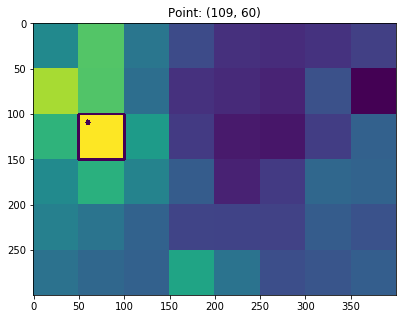

NOT GOOD PREDICTIONS
I: 1
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], [(310.0580590792634, 'water')], 

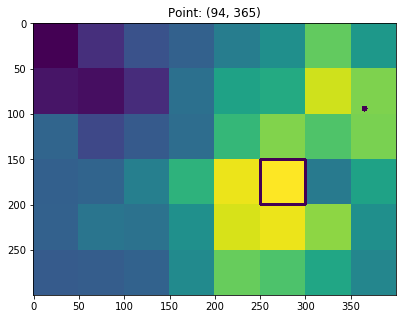

I: 2
SECTORS: [[(114.49454135459908, 'water')], [(114.49454135459908, 'water')], [(114.49454135459908, 'water')], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')], [(156.4736399525492, 'water')]

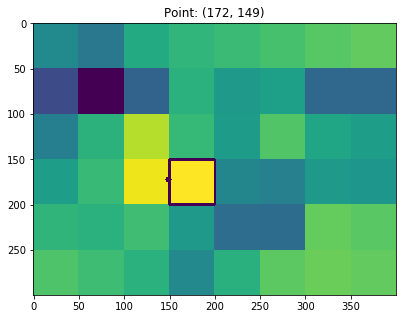

I: 10
SECTORS: [[(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [(144.9310180741169, 'water')], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

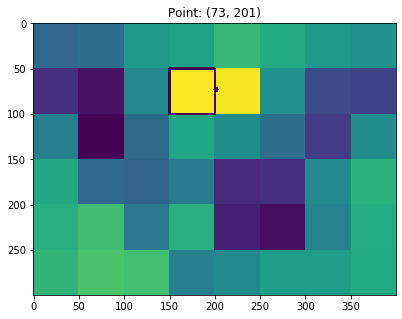

I: 14
SECTORS: [[], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879, 'water')], [(178.7568180517879,

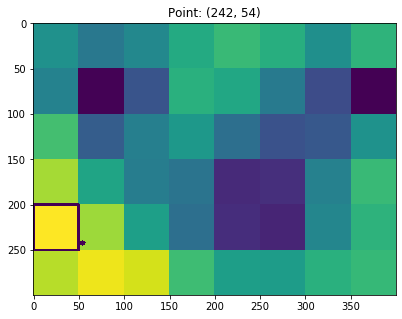

I: 16
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

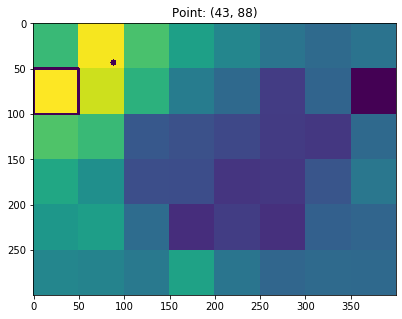

I: 19
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [(107.28000745712129, 'water')], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

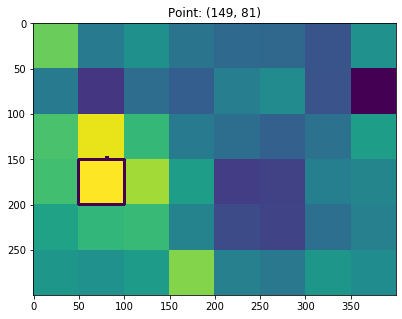

I: 20
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [(113.14592347937243, 'water')], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

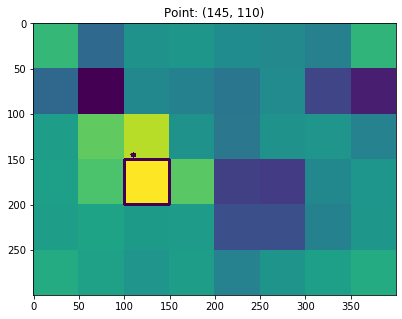

I: 23
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841484, 'water')], [(241.04978738841

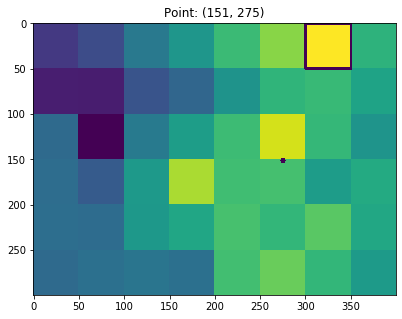

I: 30
SECTORS: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087546613, 'water')], [(289.74644087

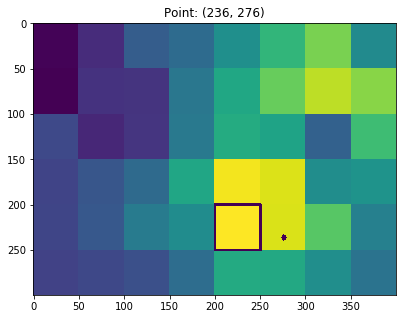

I: 37
SECTORS: [[(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'water')], [(248.8051446413438, 'wa

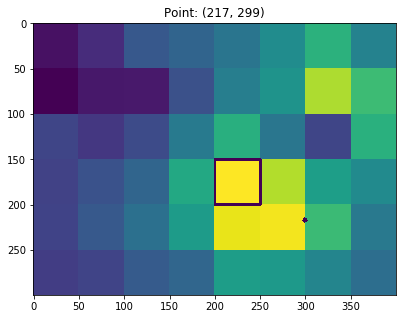

In [199]:
show_img(0.71, is_in_k[:,0])

In [192]:
point_to_probs, agent_cds = calculate_cell_probs_for_all_points()

In [202]:
point_to_probs[1][0]

(94, 365)

In [203]:
agent_cds[1].sectors

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.0580590792634, 'water')],
 [(310.058

In [201]:
probs = point_to_probs[1][1]

max_proba_point_id = np.argmax(probs)
max_center_point = img_cds.center_points[max_proba_point_id]

cd = create_circle_diagram(sectors_count, max_center_point, img_osm)

In [211]:
need_to_point = points_to_centers_6_8[point_to_probs[1][0][::-1]]
print(need_to_point)
should_be_cd = create_circle_diagram(sectors_count, need_to_point[::-1], img_osm)

(375.0, 75.0)


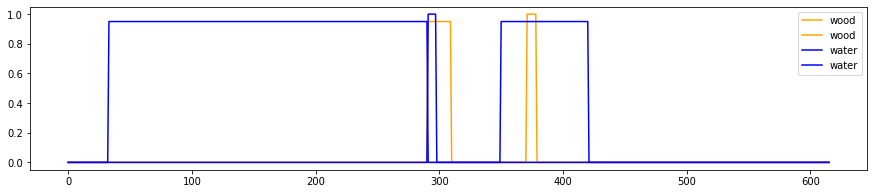

In [215]:
def draw_sectors(sectors, shift=0.0):
    plt.figure(figsize=(15, 3))
    shift = int(len(sectors) * shift)
    for t, c in [('wood', 'orange'), ('water', 'blue')]:
        for i, k in enumerate([0.95, 1.0, 1.05, 1.1]):
            x = range(len(sectors))
            y = [(s[i][1] == t if i < len(s) else 0) for s in sectors]
            y = y[shift:] + y[:shift]
            if any(y):
                plt.plot(x, np.array(y) * k, label=t, color=c)
    plt.legend()
    plt.show()
    
draw_sectors(agent_cds[1].sectors)

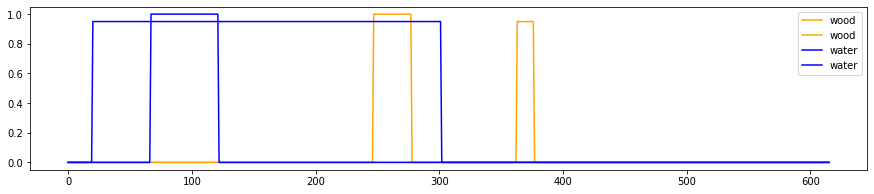

In [216]:
draw_sectors(cd.sectors)

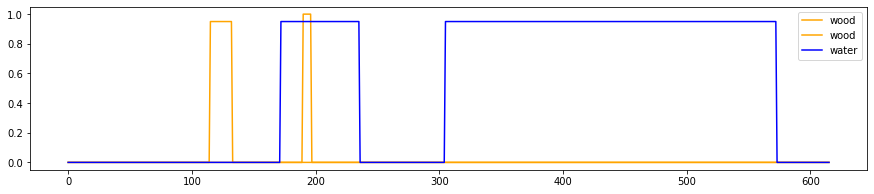

In [217]:
draw_sectors(should_be_cd.sectors, shift=0.3)

In [147]:
point_to_probs[0]

((316, 231),
 array([2.07261382e-02, 1.70665145e-02, 1.46736836e-02, 1.84740621e-02,
        2.15706668e-02, 2.06557608e-02, 2.70952911e-02, 2.96249678e-02,
        1.77350996e-02, 1.40754759e-12, 1.10140599e-02, 1.94593454e-02,
        2.05853835e-02, 1.60812312e-02, 1.83333030e-02, 7.67113435e-03,
        2.76231214e-02, 1.22808527e-02, 1.48144384e-02, 2.18521763e-02,
        1.99167984e-02, 1.84740621e-02, 1.67146276e-02, 2.48080262e-02,
        2.97344428e-02, 1.77702883e-02, 1.80517978e-02, 2.14299120e-02,
        1.36884003e-02, 1.43217967e-02, 2.13595346e-02, 2.30837804e-02,
        3.05789713e-02, 2.57933095e-02, 1.98112323e-02, 1.92130246e-02,
        1.30550039e-02, 1.33013247e-02, 2.55118000e-02, 2.47376488e-02,
        2.95233106e-02, 2.99807636e-02, 2.94998519e-02, 2.31893465e-02,
        2.93825559e-02, 3.04734053e-02, 3.02974618e-02, 2.89602916e-02]))

In [165]:
max_center_point

(225.0, 25.0)

**Надо дебажить...**

In [116]:
center_point = points[0]
print(center_point)

(316, 231)


In [120]:
img_osm.img_cutted_shape

(300, 400, 3)

In [155]:
img_osm.osm_objects

**TODO: вывести диаграмму для точки, для которой было получено предсказание (в которую мы решили, что агент попал)**

Сравнить, действительно ли диаграммы похожи

**Внутри объекта - объект на 360.**